In [0]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/drive', force_remount=False)

In [0]:
import os
from pathlib import Path

# folder 변수에 구글드라이브에 프로젝트를 저장한 디렉토리를 입력하세요!
# My Drive 밑에 저장했다면 그대로 두시면 됩니다.
folder = ""
project_dir = "Deep_learning/03_rnn_tf"

base_path = Path("/content/drive/My Drive/")
project_path = base_path / folder / project_dir
os.chdir(project_path)
for x in list(project_path.glob("*")):
    if x.is_dir():
        dir_name = str(x.relative_to(project_path))
        os.rename(dir_name, dir_name.split(" ", 1)[0])
print(f"현재 디렉토리 위치: {os.getcwd()}")

현재 디렉토리 위치: /content/drive/My Drive/Deep_learning/03_rnn_tf


In [0]:
# !pip install tensorflow-gpu==2.0.0

## 1. Package load

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import check_util.checker as checker
from IPython.display import clear_output

import os
import time
import glob
import csv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import layers

print('tensorflow version: {}'.format(tf.__version__))
print('GPU 사용 가능 여부: {}'.format(tf.test.is_gpu_available()))

tensorflow version: 2.2.0-rc3
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU 사용 가능 여부: True


## 2. 하이퍼파라미터 세팅

In [0]:
batch_size = 128
max_epochs = 30
learning_rate = 3e-5
hidden_sizes = [100, 100] # hidden_sizes must be a list

## 3. 데이터 전처리 함수 정의

지난 10년간의(2009년~2018년) 서울시 기후 데이터를 활용.

 데이터셋은 [기상자료개방포털](https://data.kma.go.kr/)에서 받은 자료

In [0]:
def preprocess(all_files):
    data_0 = []  # 기온
    data_1 = []  # 강수량
    data_2 = []  # 풍속
    data_3 = []  # 습도
    data_4 = []  # 증기압
    data_5 = []  # 이슬점 온도
    data_6 = []  # 현지 기압
    data_7 = []  # 해면 기압
    data_8 = []  # 지면 온도
    for f in all_files:
        with open(f, encoding='euc-kr') as c:
            csv_reader = csv.reader(c, delimiter=',')
            header = True
            for col in csv_reader:
                if header:
                    header = False
                    continue
                data_0.append(
                    float(col[2])) if col[2] != '' else data_0.append(0.0)
                data_1.append(
                    float(col[3])) if col[3] != '' else data_1.append(0.0)
                data_2.append(
                    float(col[4])) if col[4] != '' else data_2.append(0.0)
                data_3.append(
                    float(col[6])) if col[6] != '' else data_3.append(0.0)
                data_4.append(
                    float(col[7])) if col[7] != '' else data_4.append(0.0)
                data_5.append(
                    float(col[8])) if col[8] != '' else data_5.append(0.0)
                data_6.append(
                    float(col[9])) if col[9] != '' else data_6.append(0.0)
                data_7.append(
                    float(col[10])) if col[10] != '' else data_7.append(0.0)
                data_8.append(
                    float(col[22])) if col[22] != '' else data_8.append(0.0)

    data = np.zeros((len(data_0), 9))
    for i, d in enumerate(data):
        data[i, 0] = data_0[i]
        data[i, 1] = data_1[i]
        data[i, 2] = data_2[i]
        data[i, 3] = data_3[i]
        data[i, 4] = data_4[i]
        data[i, 5] = data_5[i]
        data[i, 6] = data_6[i]
        data[i, 7] = data_7[i]
        data[i, 8] = data_8[i]

    return data.astype(np.float32)

In [0]:
data_dir = './data/climate_seoul'

train_data = preprocess(sorted(glob.glob(os.path.join(data_dir, 'train', '*'))))
val_data = preprocess(sorted(glob.glob(os.path.join(data_dir, 'val', '*'))))
test_data = preprocess(sorted(glob.glob(os.path.join(data_dir, 'test', '*'))))

In [0]:
train_data

array([[  -7.6,    0. ,    2.1, ..., 1013.7, 1024.9,  -10.1],
       [  -7.8,    0. ,    2.3, ..., 1013.7, 1024.9,  -10.3],
       [  -8.1,    0. ,    2. , ..., 1013.8, 1025.1,  -10.8],
       ...,
       [  -4.6,    0. ,    1.1, ..., 1024.8, 1036. ,   -4.1],
       [  -5.4,    0. ,    1.3, ..., 1024.4, 1035.6,   -5. ],
       [  -5.2,    0. ,    1.6, ..., 1024.6, 1035.8,   -5.1]],
      dtype=float32)

In [0]:
print("shape of train data: {}".format(train_data.shape))
print("shape of val data: {}".format(val_data.shape))
print("shape of test data: {}".format(test_data.shape))

shape of train data: (70133, 9)
shape of val data: (8760, 9)
shape of test data: (8760, 9)


## 4. 데이터 샘플 시각화

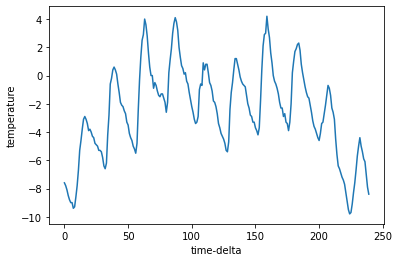

In [0]:
start = 0
dt = 240
plt.plot(train_data[start:start+dt, 0])
plt.ylabel("temperature")
plt.xlabel("time-delta")
plt.show()

## 5. Dataset 만들기

In [0]:
def make_dataset(data, seq_length=720, target_delay=24, strides=3,
                 mode='train', train_mean=None, train_std=None):
    '''
        각 인수에 대한 설명은 위의 'Dataset만들기' 설명을 참고하세요.
    '''
    assert mode in ['train', 'val', 'test']
    if mode is not 'train':
        if train_mean is None or train_std is None:
            print('Current mode is {}'.format(mode))
            print('This mode needs mean and std of train data')
            assert False

    # 정규화
    ## 코드 시작 ##
    if mode is 'train':
        mean = np.mean(data,axis=0)    # 위의 설명 1-1 을 참고하여 None을 채우세요.
        std = np.std(data,axis=0)     # 위의 설명 1-1 을 참고하여 None을 채우세요.
    else: 
        mean = train_mean    # 위의 설명 1-2 를 참고하여 None을 채우세요.
        std = train_std     # 위의 설명 1-2 를 참고하여 None을 채우세요.
    data = (data-mean) / std        # 위의 설명 1-3 을 참고하여 None을 채우세요.
    ## 코드 종료 ##
    
    # 입력, 타겟 데이터 생성
    sequence = []
    target = []
    for index in range(len(data) - seq_length - target_delay+1):
        if index % strides == 0:
            
            ## 코드 시작 ##
            sequence.append(data[index:index+seq_length])    # 위의 설명 2-1 을 참고하여 None을 채우세요.
            target.append(data[index+seq_length+target_delay][0])      # 위의 설명 2-2 를 참고하여 None을 채우세요.
            ## 코드 종료 ##

    if mode is 'train':
        return np.array(sequence), np.array(target), mean, std
    else:
        return np.array(sequence), np.array(target)

이제 학습용, 검증용, 테스트용 dataset.

In [0]:
train_sequences, train_labels, train_mean, train_std = make_dataset(train_data, mode='train')
val_sequences, val_labels = make_dataset(val_data, mode='val', train_mean=train_mean, train_std=train_std)
test_sequences, test_labels = make_dataset(test_data, mode='test', train_mean=train_mean, train_std=train_std)

#### Input pipeline 만들기

In [0]:
# shuffle의 인자로 buffer_size가 필요한데 이는 전체 데이터셋 갯수로 하는게 좋습니다.
N = BUFFER_SIZE = len(train_sequences) # number of samples in train_dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_sequences, train_labels))
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.repeat()

In [0]:
val_dataset = tf.data.Dataset.from_tensor_slices((val_sequences, val_labels))
val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.repeat()

In [0]:
test_dataset = tf.data.Dataset.from_tensor_slices((test_sequences, test_labels))
test_dataset = test_dataset.batch(batch_size)

## 6. 베이스라인 성능 측정

In [0]:
for sequences, targets in test_dataset:
    zz=sequences
print(zz)

tf.Tensor(
[[[-7.8087455e-01 -1.1775388e-01  3.5812479e-02 ...  4.6323413e-01
    5.1406306e-01 -1.0102018e+00]
  [-7.8087455e-01 -1.1775388e-01 -1.8090615e-01 ...  4.7485763e-01
    5.2637136e-01 -1.0177178e+00]
  [-8.1613463e-01 -1.1775388e-01 -5.4210395e-01 ...  4.6323413e-01
    5.1406306e-01 -1.0628139e+00]
  ...
  [-1.5918561e+00 -1.1775388e-01 -1.8090615e-01 ...  2.1565735e-02
    6.4697459e-02 -1.4160661e+00]
  [-1.5477811e+00 -1.1775388e-01  6.1372888e-01 ... -1.6777291e-03
    4.0077109e-02 -1.3935180e+00]
  [-1.5389661e+00 -1.1775388e-01  2.5253111e-01 ... -7.4912552e-03
    3.3919204e-02 -1.3784860e+00]]

 [[-8.6020976e-01 -1.1775388e-01 -5.4210395e-01 ...  4.6904409e-01
    5.2021718e-01 -1.0177178e+00]
  [-8.5139471e-01 -1.1775388e-01 -8.3106220e-01 ...  4.6904409e-01
    5.2021718e-01 -9.9516982e-01]
  [-8.1613463e-01 -1.1775388e-01 -3.9762485e-01 ...  4.9810109e-01
    5.5099547e-01 -9.4255781e-01]
  ...
  [-1.6006712e+00 -1.1775388e-01  1.2638848e+00 ... -7.1415216e-02

In [0]:
zz[len(zz)-1,-1,0]

<tf.Tensor: shape=(), dtype=float32, numpy=-1.8915669>

In [0]:
def eval_baseline(dataset, loss_fn):
    mean_loss = tf.keras.metrics.Mean()
    for sequences, targets in dataset:
        predictions = sequences[-1,-1,0]
        loss = loss_fn(predictions,targets)
 
        mean_loss(loss)
        
    print('Baseline Average Loss: {:.4f}'.format(mean_loss.result()))
    return mean_loss.result()

In [0]:
loss_object = tf.keras.losses.MeanSquaredError()
baseline_loss = eval_baseline(test_dataset, loss_object)

Baseline Average Loss: 0.4178


베이스라인 모델의 예측 기온과 실제 기온

In [0]:
for i in range(10):
    data_idx = np.random.randint(len(test_sequences))
    pred = test_sequences[data_idx, -1, 0]
    # 예측 기온을 normalization 이전 상태(섭씨 단위)로 되돌리는 작업
    pred = pred * train_std[0] + train_mean[0]
    # 실제 기온을 normalization 이전 상태(섭씨 단위)로 되돌리는 작업
    target = test_labels[data_idx] * train_std[0] + train_mean[0]
    print('예측 기온: {:.1f} / 실제 기온: {:.1f} / 차이: {:.1f}'.format(
        pred, target, pred - target))

예측 기온: 19.8 / 실제 기온: 21.5 / 차이: -1.7
예측 기온: 23.8 / 실제 기온: 23.6 / 차이: 0.2
예측 기온: 7.8 / 실제 기온: 3.6 / 차이: 4.2
예측 기온: 21.3 / 실제 기온: 21.9 / 차이: -0.6
예측 기온: 3.5 / 실제 기온: 9.3 / 차이: -5.8
예측 기온: 22.7 / 실제 기온: 21.0 / 차이: 1.7
예측 기온: 5.2 / 실제 기온: 10.0 / 차이: -4.8
예측 기온: -8.5 / 실제 기온: -5.5 / 차이: -3.0
예측 기온: 22.4 / 실제 기온: 21.8 / 차이: 0.6
예측 기온: 1.7 / 실제 기온: 7.4 / 차이: -5.7


## 7. 네트워크 설계

LSTM

In [0]:
sequences.shape

TensorShape([68, 720, 9])

In [0]:
model = tf.keras.Sequential()

In [0]:
num_layers = len(hidden_sizes)
for i in range(num_layers - 1):
    model.add(tf.keras.layers.LSTM(100,input_shape=(720,9),return_sequences=True))
    model.add(tf.keras.layers.LSTM(100,return_sequences = False))
    model.add(tf.keras.layers.Dense(1))

In [0]:
for step, (sequences, targets) in enumerate(train_dataset.take(1)):
    predictions = model(sequences)

In [0]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 720, 100)          44000     
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 124,501
Trainable params: 124,501
Non-trainable params: 0
_________________________________________________________________


## 8. Loss function, Optimizer 정의

In [0]:
model.compile(loss=tf.keras.losses.MeanSquaredError(), 
              optimizer=tf.optimizers.Adam(learning_rate=learning_rate), 
              metrics=['mse'])


## 모델 저장하기

weight를 저장

In [0]:
checkpoint_path = "./train/exp_rnn/720_stride=3_cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# 체크포인트 콜백 만들기
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,save_weights_only=True, verbose=1)

## 8. Training

In [0]:
train_dataset

<RepeatDataset shapes: ((None, 720, 9), (None,)), types: (tf.float32, tf.float32)>

In [0]:
model.fit(train_dataset, steps_per_epoch = (len(train_data)/batch_size), 
          validation_data = val_dataset, 
          validation_steps= len(val_data)/batch_size,
          epochs= max_epochs,
          callbacks= [cp_callback])

Epoch 1/30
548/547 [==============================] - ETA: 0s - loss: 0.1937 - mse: 0.1938
Epoch 00001: saving model to ./train/exp_rnn/720_stride=3_cp-0001.ckpt
548/547 [==============================] - 50s 90ms/step - loss: 0.1937 - mse: 0.1938 - val_loss: 0.1160 - val_mse: 0.1164
Epoch 2/30
548/547 [==============================] - ETA: 0s - loss: 0.0969 - mse: 0.0969
Epoch 00002: saving model to ./train/exp_rnn/720_stride=3_cp-0002.ckpt
548/547 [==============================] - 49s 89ms/step - loss: 0.0969 - mse: 0.0969 - val_loss: 0.0836 - val_mse: 0.0834
Epoch 3/30
548/547 [==============================] - ETA: 0s - loss: 0.0817 - mse: 0.0817
Epoch 00003: saving model to ./train/exp_rnn/720_stride=3_cp-0003.ckpt
548/547 [==============================] - 49s 89ms/step - loss: 0.0817 - mse: 0.0817 - val_loss: 0.0773 - val_mse: 0.0771
Epoch 4/30
548/547 [==============================] - ETA: 0s - loss: 0.0759 - mse: 0.0759
Epoch 00004: saving model to ./train/exp_rnn/720_strid

## 9. test

학습된 모델의 예측 기온과 실제 기온을 몇가지 살펴보면 다음과 같습니다.

In [0]:
pred = []
target = []
for i in range(len(test_sequences)):
    pred_before = model(test_sequences[i:i+1, :, :]).numpy()[0, 0]
    # 예측 기온을 normalization 이전 상태(섭씨 단위)로 되돌리는 작업
    pred=np.append(pred,pred_before * train_std[0] + train_mean[0])

    # 실제 기온을 normalization 이전 상태(섭씨 단위)로 되돌리는 작업
    target=np.append(target,test_labels[i] * train_std[0] + train_mean[0])

In [0]:
print("오차 평균 = ",abs(target-pred).mean())
print("오차 편차 = ",(target-pred).std())

오차 평균 =  2.4478431306872284
오차 편차 =  3.212323696776496


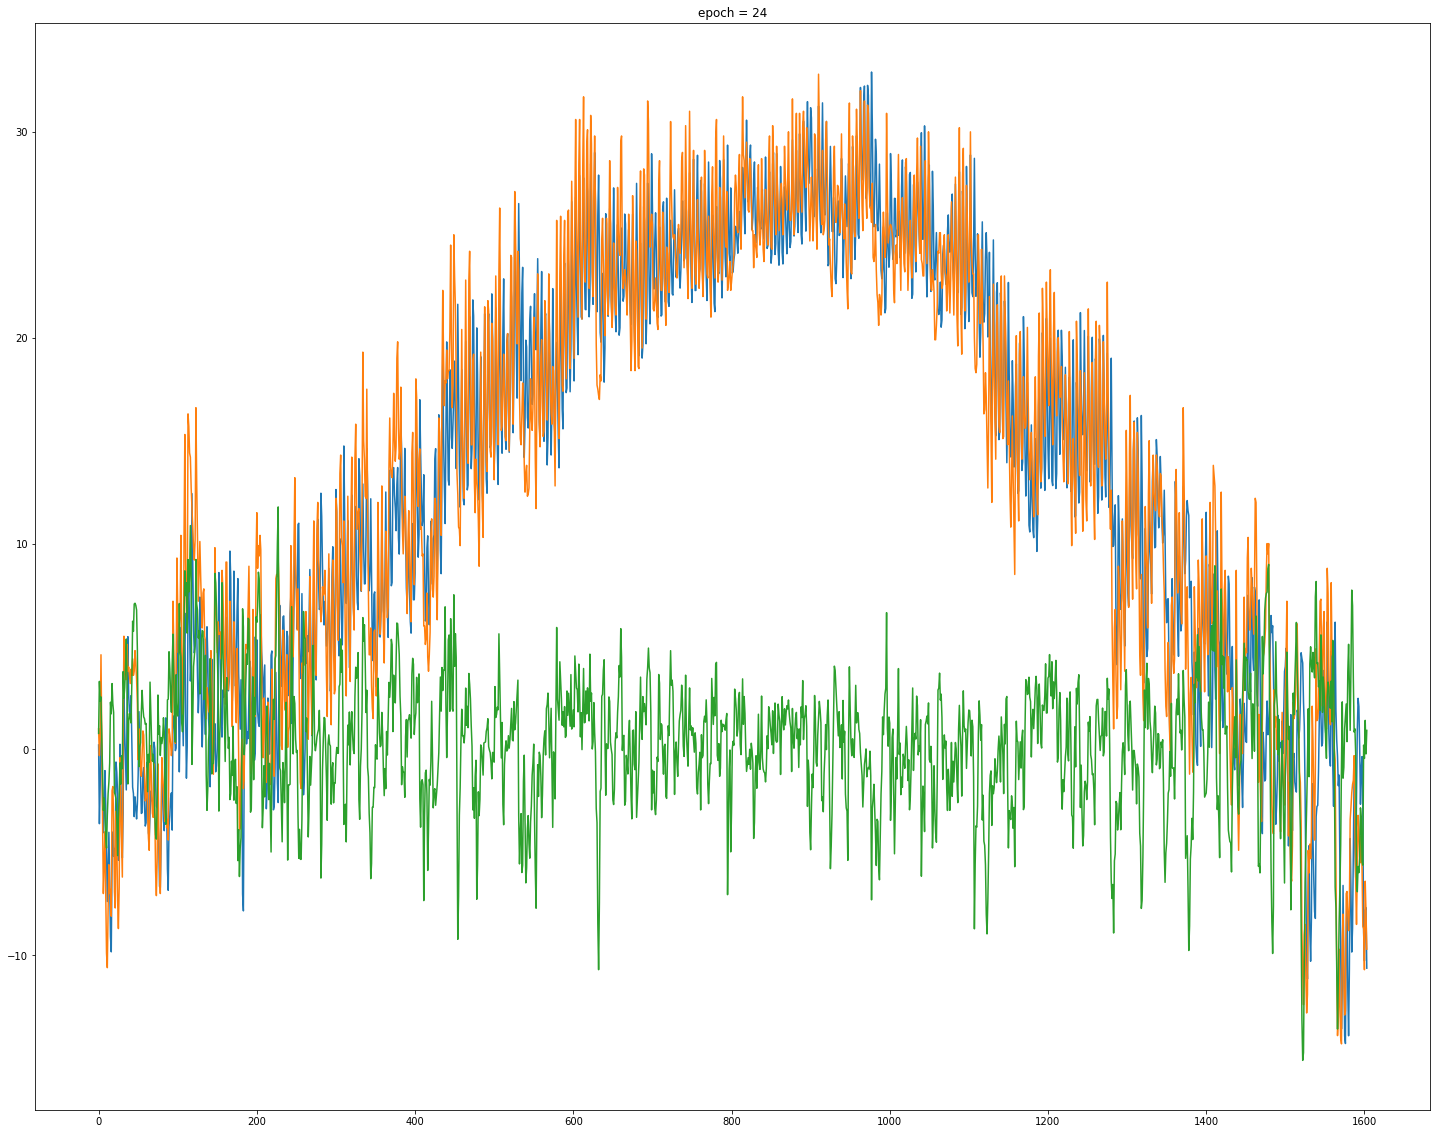

In [0]:
plt.figure(figsize=(25,20))
plt.plot(range(len(test_sequences)),pred,range(len(test_sequences)),target,range(len(test_sequences)),target-pred)
plt.title('epoch = 24')
plt.show()

<font color='green'>초록색 :</font> 실제기온 - 예측기온

In [0]:
# 마지막 모델 (epoch=30)
model.load_weights('./train/exp_rnn/720_cp-0030.ckpt')
pred = []
target = []
for i in range(len(test_sequences)):
    
    pred_before = model(test_sequences[i:i+1, :, :]).numpy()[0, 0]
    # 예측 기온을 normalization 이전 상태(섭씨 단위)로 되돌리는 작업
    pred=np.append(pred,pred_before * train_std[0] + train_mean[0])


    # 실제 기온을 normalization 이전 상태(섭씨 단위)로 되돌리는 작업
    target=np.append(target,test_labels[i] * train_std[0] + train_mean[0])


print("오차 평균 = ",abs(target-pred).mean())
print("오차 편차 = ",(target-pred).std())

오차 평균 =  2.4244397804326843
오차 편차 =  3.165285216113646


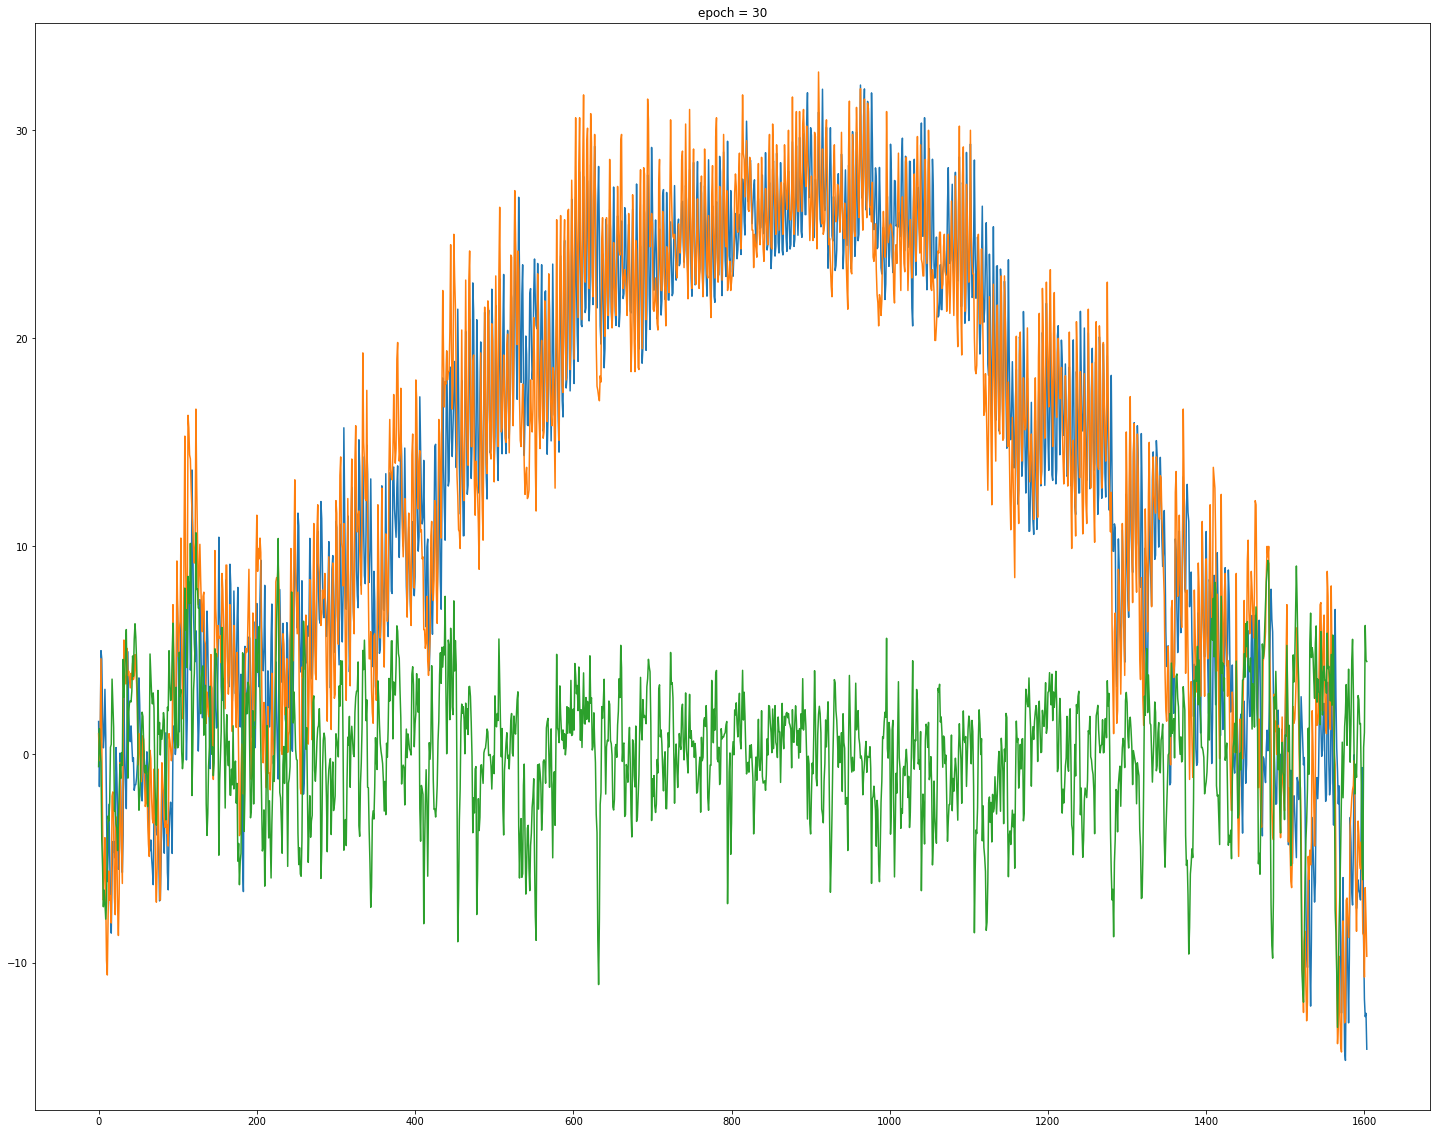

In [0]:
plt.figure(figsize=(25,20))
plt.plot(range(len(test_sequences)),pred,range(len(test_sequences)),target,range(len(test_sequences)),target-pred)
plt.title('epoch = 30')
plt.show()
